# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [2]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_middle_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_middle_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [3]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [4]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (964075, 110)
Our input array Uy is of shape: (964075, 110)
Printing a row of Ux: 
 [0.07843621 0.31118352 0.68245424 1.15863002 1.69435217 2.2377946
 2.73607737 3.14059293 3.41183529 3.52330289 3.63726074 3.7439734
 3.84549407 3.94281205 4.03640323 4.12650964 4.2132592  4.29672103
 4.37693287 4.45391539 4.52767992 4.59823263 4.6655769  4.72971455
 4.79064658 4.84837353 4.90289569 4.95421322 5.00232621 5.04723472
 5.08893877 5.12743839 5.16273359 5.19482437 5.22371075 5.24939272
 5.2718703  5.29114348 5.30721227 5.32007667 5.32973668 5.33619229
 5.33944353 5.33997115 5.33936904 5.33787084 5.33552701 5.33235975
 5.32837974 5.3235924  5.31800058 5.31160582 5.30440894 5.29641041
 5.28761047 5.27800926 5.26760686 5.25640331 5.24439864 5.23159284
 5.21798594 5.20357794 5.18836883 5.17235862 5.15554731 5.13793491
 5.1195214  5.1003068  5.0802911  5.05947431 5.03785642 5.01543743
 4.99221734 4.96819616 4.94337388 4.9177505  4.89132603 4.86410046
 4.8360738  4.8

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [5]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  175 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [6]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [7]:
ratio_pts = 0.01
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(9625, 110) (9625, 110)


In [8]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  55  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

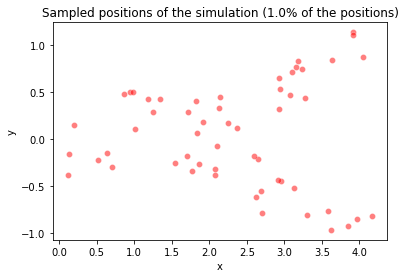

In [9]:
plot_sampled_coord(new_inds) 

In [10]:
print(new_Ux)

[[0.06598187 0.25670229 0.55084151 ... 2.51511171 2.47896831 2.44227292]
 [0.01822349 0.06614118 0.13306091 ... 0.49577011 0.48856679 0.48125408]
 [0.06441595 0.25109322 0.5398679  ... 2.481933   2.44626963 2.41006156]
 ...
 [0.0680136  0.26761562 0.58127622 ... 2.85725826 2.8164228  2.77496189]
 [0.06685035 0.26296953 0.57104399 ... 2.80158018 2.76153202 2.72087054]
 [0.07571559 0.29995296 0.65629618 ... 3.4415466  3.39267592 3.34305416]]


Let's flatten our matrices into a single matrix with dimensions $(N_s, (2 N_u N_t))$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [11]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(175, 12100)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u}}$.

In [12]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

12100


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t :

In [14]:
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='middle_small')

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [2]:
ratios = [0.1, 0.5]
size = ['very_small', 'middle_small', 'small']

name = 'processed_'+str(size[1])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_middle_small_0.1_0.5


In [3]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[1])+"/"+name, "rb"))

In [4]:
print(flattened_array)

[[ 6.59818698e-02  1.82234920e-02  6.44159502e-02 ...  1.03034493e+00
  -9.73947264e-03 -1.67477632e-02]
 [ 5.29771523e-02  1.32216300e-02  4.90189335e-02 ...  9.93200215e-01
   5.02639122e-03  1.41599883e-03]
 [ 8.25671280e-02  2.32952726e-02  6.87771891e-02 ...  1.77500861e+00
   3.44533164e-04  1.81417079e-02]
 ...
 [ 2.19606656e-01  2.55903473e-02  2.29397872e-01 ...  1.46759534e+00
   7.42708226e-02 -1.34336791e-02]
 [ 2.41341112e-01  5.06083120e-02  2.15209040e-01 ...  4.44840207e+00
   4.35858394e-02  2.36892166e-02]
 [ 6.98710694e-02  1.96083000e-02  6.43463295e-02 ...  1.38366628e+00
  -1.23426650e-03  1.73919218e-03]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [5]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(157, 60500)
(18, 60500)


## 4. Feed-forward auto-encoder  <a name="autoencoder"></a>

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [6]:
# define network parameters
learning_rates =[0.1, 0.05, 0.01, 0.005, 0.001]
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 0.872 	 Average Test Error: 0.879
 
Learning rate =  0.05

Performance of 5 fold cross validation: 
Average Training Error: 0.971 	 Average Test Error: 0.972
 
Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 0.388 	 Average Test Error: 0.303
 
Learning rate =  0.005

Performance of 5 fold cross validation: 
Average Training Error: 0.429 	 Average Test Error: 0.329
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.398 	 Average Test Error: 0.320
 

Best learning rate is  0.01  with a best error of :  0.30325559044845574



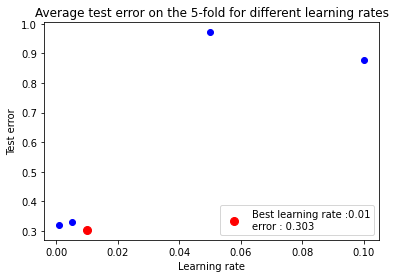

In [7]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates,  dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [8]:
# define network parameters
lr = best_lr # from above
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 4, 5, 6, 7, 8, 9, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.336 	 Average Test Error: 0.327
 
Number of neurons =  4

Performance of 5 fold cross validation: 
Average Training Error: 0.290 	 Average Test Error: 0.412
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.388 	 Average Test Error: 0.303
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.414 	 Average Test Error: 0.368
 
Number of neurons =  7

Performance of 5 fold cross validation: 
Average Training Error: 0.438 	 Average Test Error: 0.395
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.326 	 Average Test Error: 0.302
 
Number of neurons =  9

Performance of 5 fold cross validation: 
Average Training Error: 0.391 	 Average Test Error: 0.395
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.480 	 Average Test Error: 0.467
 

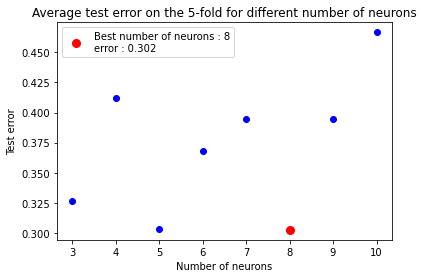

In [9]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons,  dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [6]:
# define network parameters
learningRate= 0.01
epochs=50
input_size=x_train.shape[1]
k_folds = 5
neuron_ = 8

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.562 Test Error:0.567
Epoch:2/50 Training Error:1.147 Test Error:1.130
Epoch:3/50 Training Error:0.372 Test Error:0.573
Epoch:4/50 Training Error:0.308 Test Error:0.350
Epoch:5/50 Training Error:0.278 Test Error:0.393
Epoch:6/50 Training Error:0.328 Test Error:0.747
Epoch:7/50 Training Error:0.322 Test Error:0.410
Epoch:8/50 Training Error:0.355 Test Error:0.402
Epoch:9/50 Training Error:0.322 Test Error:0.372
Epoch:10/50 Training Error:0.302 Test Error:0.382
Epoch:11/50 Training Error:0.369 Test Error:0.501
Epoch:12/50 Training Error:0.339 Test Error:0.401
Epoch:13/50 Training Error:0.339 Test Error:0.335
Epoch:14/50 Training Error:0.300 Test Error:1.055
Epoch:15/50 Training Error:0.432 Test Error:0.925
Epoch:16/50 Training Error:0.329 Test Error:0.412
Epoch:17/50 Training Error:0.344 Test Error:0.301
Epoch:18/50 Training Error:0.371 Test Error:0.402
Epoch:19/50 Training Error:0.335 Tes

Epoch:10/50 Training Error:0.380 Test Error:0.346
Epoch:11/50 Training Error:0.419 Test Error:0.315
Epoch:12/50 Training Error:0.346 Test Error:0.212
Epoch:13/50 Training Error:0.366 Test Error:0.395
Epoch:14/50 Training Error:0.356 Test Error:4.063
Epoch:15/50 Training Error:0.388 Test Error:0.940
Epoch:16/50 Training Error:0.305 Test Error:0.437
Epoch:17/50 Training Error:0.482 Test Error:0.400
Epoch:18/50 Training Error:0.376 Test Error:0.398
Epoch:19/50 Training Error:0.382 Test Error:0.547
Epoch:20/50 Training Error:0.356 Test Error:1.578
Epoch:21/50 Training Error:0.408 Test Error:0.373
Epoch:22/50 Training Error:0.411 Test Error:0.363
Epoch:23/50 Training Error:0.402 Test Error:0.233
Epoch:24/50 Training Error:0.407 Test Error:0.333
Epoch:25/50 Training Error:0.363 Test Error:0.350
Epoch:26/50 Training Error:0.333 Test Error:0.468
Epoch:27/50 Training Error:0.350 Test Error:0.273
Epoch:28/50 Training Error:0.369 Test Error:0.711
Epoch:29/50 Training Error:0.448 Test Error:0.536


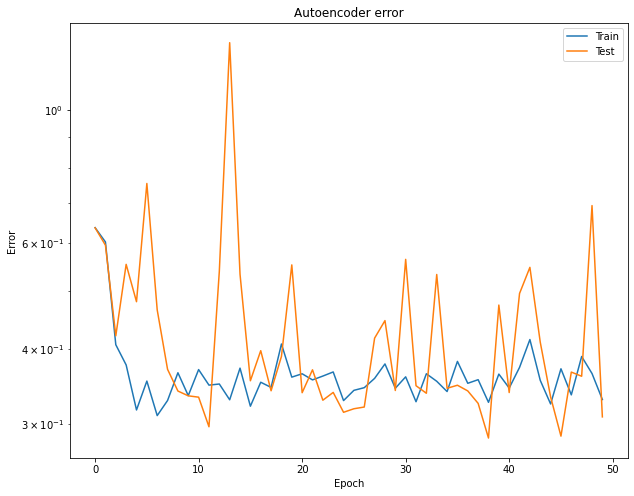

0.30832868070334596

In [7]:
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=neuron_)

#### Quality of the compression on the test set using the tuned parameters :

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table :

In [10]:
import glob
import os 
import _pickle as cPickle

dataset = 'very_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= 0.01
neuron_ = 8

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []

for f in filenames:
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[1]
    model = Autoencoder(input_size, neuron_)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train)
    test_loader = DataLoader(x_test)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch(test_loader, model)
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)

In [11]:
from pandas import *

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3],
                   '5%' : test_errors[3:6],
                   '2%' : test_errors[6:9]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

,10%,5%,2%
,,,
50%,0.143501,0.384466,0.116569
25%,0.229321,0.353863,0.340060
10%,0.381651,0.152666,0.348041


Table of relative error depending on the sampling of the dataset
x : sampling of times
y : sampling of positions


In [12]:
#Save in pickles

name = "train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 4. Passer en 2D 

Instead of flattenning our initial dataset into a colummn vector for each simulation, we split it into a 2D matrix for each simulation such as the following:

$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [16]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 1100, 110)

## 5. Passer en 4D

In [11]:
flattened_array_4d = flatten_4d(new_Ux, new_Uy, ratio_pts)
flattened_array_4d.shape

IndexError: index 55 is out of bounds for axis 1 with size 55

In [ ]:
flattened_array_4d = normalize(flattened_array_4d)

In [ ]:
x_train, x_test = train_test_split(flattened_array_4d, test_size=0.1, random_state=seed)

In [ ]:
import h5py

In [ ]:
hf = h5py.File('trainset.h5', 'w')
hf.create_dataset('dataset_1', data=x_train)

In [ ]:
hf = h5py.File('testset.h5', 'w')
hf.create_dataset('dataset_1', data=x)

## 6. Discussion & conclusion